In [1]:
# visualize probability mass function of ensemble classifiers error rate

%matplotlib inline
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0) # strictly greater than half
    probs = [comb(n_classifier, k) *
            error**k *
            (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

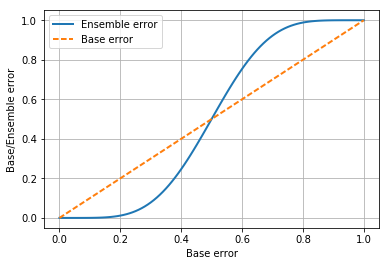

In [2]:
# error rates for base errors from 0.0 to 1.0
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
            for error in error_range]
import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
        linestyle='--', label='Base error',
        linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# error probability of ensemble is better than error of individual base classifier as long as base classifier performs
# better than random guessing (e < 0.50).

In [3]:
# Implementing a simple majority vote classifier
# Weighted majority vote

# numpy.bincount count number of occurence of each value in array and returns array of proportions
# numpy.bincount can be scaled by a weights array
# numpy.argmax returns index with max value
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                     weights=[0.2, 0.2, 0.6]))


1

In [4]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6]) # axis 0 - vertically down row
print('probabilities: %s' %p)
print('majority vote: %s' % np.argmax(p))

probabilities: [ 0.58  0.42]
majority vote: 0


In [5]:
# refer to majority_vote_classifier.py
# Combining different algorithms for classification with majority vote

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
# only use 2 features: sepal width and petal length, and 2 classes: Iris-Versicolor and Iris-Virginica
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
# split 50-50 training and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [6]:
# Train three different classifiers - logistic regression, decision tree and k-nearest neighbors
# 10-fold cross validation individually
# combine to form ensemble classifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski') # euclidean
pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels): # decision trees dont require scaling
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('Accuracy: %0.2f (+/- %-.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation:

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]


In [7]:
# Combine individual classifiers
from majority_vote_classifier import MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %-.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


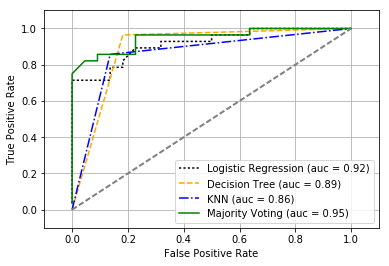

In [8]:
# Evaluating and tuning the ensemble classifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2) # diagonal
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

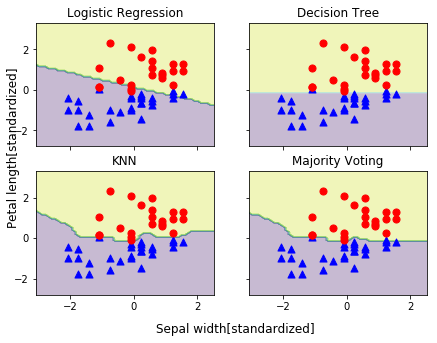

In [9]:
# Decision region of ensemble classifier

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c='blue',
                                 marker='^',
                                 s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                  c='red',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s='Sepal width[standardized]',
        ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length[standardized]',
        ha='center', va='center', fontsize=12, rotation=90)

In [11]:
# access individual parameters inside GridSearch object

mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

In [13]:
# Tune inverse regularization parameter c of logistic regression in classifier
# Tune decision tree depth via grid search

from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C':[0.001, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [25]:
# print different hyperparameter value combinations and averate ROC AUC scores
for params, mean_score, std_scores in zip(grid.cv_results_['params'],
                                   grid.cv_results_['mean_test_score'],
                                   grid.cv_results_['std_test_score']):

    print("%0.3f+/-%0.2f %r" % (mean_score, std_scores/2, params))

0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [26]:
print('Best parameters: %s' % grid.best_params_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


In [27]:
print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 1.00


In [29]:
# Bagging - building an ensemble of classifiers from bootstrap samples
# bootstrap samples (random samples with replacement)
# On wine dataset

import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1] # only consider wine classes 2 and 3
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values # only consider 2 features: Alcohol and Hue

In [30]:
# Encode the class labels into binary format
# Split training and test set
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [31]:
# scikit-learn bagging classifier algorithm

from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500, # 500 decision trees
                        max_samples=1.0, # all
                        max_features=1.0, # all
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)